In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import re
import seaborn as sns
import time

from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

#for scaling the data
from sklearn.preprocessing import RobustScaler
#for oversampling to create a balanced train set
from sklearn.utils import resample
#for spliting data into traning and testing
from sklearn.model_selection import train_test_split

#for Logistic Regression
from sklearn.linear_model import LogisticRegression
#for Support Vector Machine
from sklearn.svm import SVC
#for KNN
from sklearn.neighbors import KNeighborsClassifier
#for decision tree
from sklearn.tree import DecisionTreeClassifier
#for random forest and boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

#for metrics
from sklearn.metrics import f1_score
#from sklearn.metrics import accuracy_score, roc_auc_score,f1_score, precision_score, recall_score,classification_report,confusion_matrix

#PCA for Dimension Reduction
from sklearn.decomposition import PCA

#to perform cross validation
from sklearn.model_selection import GridSearchCV

# Getting the sense of data

In [2]:
#Load the data
df1 = pd.read_csv('datatest.txt',delimiter=",")
df2 = pd.read_csv('datatest2.txt',delimiter=",")
df3 = pd.read_csv('datatraining.txt',delimiter=",")
df = [df3,df2,df1]
df = pd.concat(df)
df = df.drop("date",1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20560 entries, 1 to 2804
Data columns (total 6 columns):
Temperature      20560 non-null float64
Humidity         20560 non-null float64
Light            20560 non-null float64
CO2              20560 non-null float64
HumidityRatio    20560 non-null float64
Occupancy        20560 non-null int64
dtypes: float64(5), int64(1)
memory usage: 1.1 MB


In [3]:
print(df["Occupancy"].value_counts()[1])
print(df["Occupancy"].value_counts()[0])

4750
15810


Occupited status: 23.103112840466927 %
Not occupited status: 76.89688715953308 %


Text(0.5, 1.0, 'Actual Raw Data: Very unbalanced')

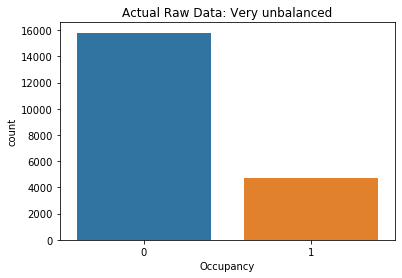

In [4]:
occupied = (df["Occupancy"].value_counts()[1]/len(df))*100
not_occupied = (df["Occupancy"].value_counts()[0]/len(df))*100

print("Occupited status:",occupied,"%")
print("Not occupited status:", not_occupied,"%")

#frequency graph of unbalaced data
sns.countplot("Occupancy",data=df).set_title('Actual Raw Data: Very unbalanced')

We can see how unbalanced our data is. There are very low number of occupied status class incompare to not occupied class (4750 VS 15810) Most of the out box classifiers from Scikit-Learn are designed to minimize error loss function (which will maximize accuracy. If we have our classifier to just classify everything to 0, then we can easily obtain the accuracy of than 76.89% but that's not a faithful. So, we have to use different robust metrics like F-score and introduce bias in samlping process.

# Data Preparation

In [5]:
#get X and Y vector
X = df.drop("Occupancy",1)
Y = df["Occupancy"]

# Resampling Techniques: Oversampling
Here we are going to oversample the least occuring class which is occupied status class. 
Oversampling introducing a bais to select more samples from occupied status class than from not occupied status class. This is done to compensate for an imblanced in the dataset. 

In [6]:
def oversample(X_train,Y_train):
    #now add training set back together
    X = pd.concat([X_train,Y_train],1)
    #print(train_concat["class"])

    #seperate non-pulsar and pulsar class
    occupied = X[X["Occupancy"] == 1]
    not_occupied  = X[X["Occupancy"] == 0]

    #use resample to create 283823 "fake/duplicate"  data
    occupiedResampled = resample(occupied, replace = True, n_samples = len(not_occupied))

    allResampled = pd.concat([not_occupied,occupiedResampled])
    #print(allResampled.shape)

    #training set ready after resampling
    X_train = allResampled.drop("Occupancy",1)
    Y_train = allResampled["Occupancy"]

    #frequency graph of unbalaced data
    #sns.countplot("Class",data=allResampled).set_title('training set after oversampling')

    return X_train,Y_train

Our training set looks much balanced now after oversampling occupied status class!!

# Hyperparamaters

In [7]:
#for log Reg
Penalty_list = [ 'l1', 'l2']
C_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
logReg_param_grid = {'penalty': Penalty_list, 'C': C_list}

#for SVM
C_list = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gamma_list = [1e-6,1e-5,1e-4,1e-3,1e-2]
Kernel_list= ['linear', 'rbf', 'poly', 'sigmoid']
svm_param_grid = {'C':C_list, 'kernel': Kernel_list, 'gamma' : Gamma_list}

#KNN 
K_list = [1, 3, 5, 7, 9]
Algorithm_list = ['auto', 'ball_tree', 'kd_tree', 'brute']
knn_param_grid = {'n_neighbors': K_list, 'algorithm': Algorithm_list}

#Decision Tree 
Criterion_list = ['gini', 'entropy']
D_list = [1,2,3,4,5]
decisionTree_param_grid = {'max_depth': D_list, 'criterion': Criterion_list}

#Random Forest 
numberOfTree_list = [5,10,50,100,500,1000,5000,10000]
Criterion_list = ['gini', 'entropy']
randomForest_param_grid = {'n_estimators': numberOfTree_list, 'criterion': Criterion_list}

#AdaBoost
n_estimators_list = [10,50,100,500]
learningRate_list = [0.0001,0.001,0.01,0.1,1.0]
adaBoost_param_grid = {'n_estimators': n_estimators_list, 'learning_rate': learningRate_list}

# Prepare models

In [8]:
#prepare models
# models = [id name, classifier, hypermater of the classifier for Cross Validation]
models = []
models.append(('Logistic Regression', LogisticRegression(),logReg_param_grid))
models.append(('K-nearest Neighbors', KNeighborsClassifier(),knn_param_grid ))
models.append(('Decision Tree', DecisionTreeClassifier(),decisionTree_param_grid))
models.append(('Random Forest', RandomForestClassifier(),randomForest_param_grid))
models.append(('AdaBoost', AdaBoostClassifier(),adaBoost_param_grid))
models.append(('Support Vector Machine', SVC(max_iter = 10000),svm_param_grid ))
#print(models)

In [9]:
%%time 
def train_model(result,name,model,hyperparam):
    
    trainingErrorForRepeats = []
    testingErrorForRepeats = []
    #run 3 times and obtain mean and standard devation of training/testing error
    for repeat in range(3):
        #find optimal combination of hyperaramaters
        grid_search = GridSearchCV(estimator=model,param_grid=hyperparam,cv=5)
        grid_search.fit(X_train,Y_train)
        
        #Find optimal hyper-paramater
        best_hyperparam = grid_search.best_params_
    
        #trainng f1 score
        y_prediction_train = grid_search.best_estimator_.predict(X_train)
        train_error_f1 = f1_score(Y_train,y_prediction_train)
       
        #testing f1 score
        y_prediction_test = grid_search.best_estimator_.predict(X_test)
        test_error_f1 = f1_score(Y_test,y_prediction_test)
        
        trainingErrorForRepeats.append(train_error_f1)
        testingErrorForRepeats.append(test_error_f1)
        
    trainMean = np.mean(trainingErrorForRepeats)
    trainMean = round((trainMean*100),2)
    trainStd = np.std(trainingErrorForRepeats)
    trainStd = round((trainStd*100),2)
    trainError = str(trainMean) + u"\u00B1"+ str(trainStd)
   
    testMean = np.mean(testingErrorForRepeats)
    testMean = round((testMean*100),2)
    testStd = np.std(testingErrorForRepeats)
    testStd = round((testStd*100),2)
    testError = str(testMean) + u"\u00B1"+ str(testStd)
    
    #toAdd = [name, best_hyperparam, train_error, test_error]
    toAdd = [name, best_hyperparam, trainError, testError]
    result.append(toAdd)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 14.5 µs


In [10]:
#REAL MEAT

#Split it into train and test
train_size = [0.2,0.8]
#results
result = []
for size in train_size:
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size=size)
    X_train, Y_train = oversample(X_train,Y_train)
    for name, model, hyperparam in models:
        print("now training " , name,"in train size", size)
        start = time.clock()
        train_model(result,name,model,hyperparam)
        end = time.clock()
        print(name, " done in ", end-start)

now training  Logistic Regression in train size 0.2
Logistic Regression  done in  12.657613999999999
now training  K-nearest Neighbors in train size 0.2
K-nearest Neighbors  done in  133.67795999999998
now training  Decision Tree in train size 0.2
Decision Tree  done in  1.3222230000000081
now training  Random Forest in train size 0.2
Random Forest  done in  1849.746318
now training  AdaBoost in train size 0.2
AdaBoost  done in  193.8849949999999
now training  Support Vector Machine in train size 0.2
Support Vector Machine  done in  792.7342350000004
now training  Logistic Regression in train size 0.8
Logistic Regression  done in  314.0893109999997
now training  K-nearest Neighbors in train size 0.8
K-nearest Neighbors  done in  459.71445300000005
now training  Decision Tree in train size 0.8
Decision Tree  done in  3.503157999999985
now training  Random Forest in train size 0.8
Random Forest  done in  7916.599225999999
now training  AdaBoost in train size 0.8
AdaBoost  done in  596.99

In [11]:
print(result)

[['Logistic Regression', {'C': 0.1, 'penalty': 'l1'}, '99.13±0.0', '97.4±0.01'], ['K-nearest Neighbors', {'algorithm': 'auto', 'n_neighbors': 1}, '100.0±0.0', '96.53±0.0'], ['Decision Tree', {'criterion': 'gini', 'max_depth': 4}, '99.51±0.0', '97.62±0.01'], ['Random Forest', {'criterion': 'entropy', 'n_estimators': 10}, '99.95±0.04', '97.69±0.03'], ['AdaBoost', {'learning_rate': 1.0, 'n_estimators': 500}, '100.0±0.0', '97.32±0.0'], ['Support Vector Machine', {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}, '99.84±0.0', '96.49±0.0'], ['Logistic Regression', {'C': 0.01, 'penalty': 'l1'}, '99.19±0.0', '97.11±0.0'], ['K-nearest Neighbors', {'algorithm': 'auto', 'n_neighbors': 1}, '100.0±0.0', '97.15±0.0'], ['Decision Tree', {'criterion': 'entropy', 'max_depth': 5}, '99.4±0.0', '97.14±0.0'], ['Random Forest', {'criterion': 'entropy', 'n_estimators': 100}, '100.0±0.0', '98.24±0.09'], ['AdaBoost', {'learning_rate': 1.0, 'n_estimators': 500}, '99.31±0.0', '97.2±0.0'], ['Support Vector Machine', {'

In [12]:
def pretty_print(df):
    return display(HTML(df.to_html().replace("\\n","<br>")))

In [13]:
#strip result into multiple based on what it refeers to

modelNameResult = []
bestHyperparamaterResult = []
trainingErrorResult = []
testingErrorResult = []

for row in result:
    modelNameResult.append(row[0])
    bestHyperparamaterResult.append(row[1])
    trainingErrorResult.append(row[2])
    testingErrorResult.append(row[3])

tempDataframe = pd.DataFrame({'Classifier':modelNameResult,
                          'Optimal Hyper-paramater':bestHyperparamaterResult,
                          'Training F1 SCore':trainingErrorResult,
                          'Testing F1 Score':testingErrorResult })

train20Dataframe = tempDataframe[0:6]
train80Dataframe = tempDataframe[6:12]

#pretty_print(tempDataframe)
print("training size: 20%")
pretty_print(train20Dataframe)
print("training size: 80%")
pretty_print(train80Dataframe)

training size: 20%


,Classifier,Optimal Hyper-paramater,Training F1 SCore,Testing F1 Score
0,Logistic Regression,"{'C': 0.1, 'penalty': 'l1'}",99.13±0.0,97.4±0.01
1,K-nearest Neighbors,"{'algorithm': 'auto', 'n_neighbors': 1}",100.0±0.0,96.53±0.0
2,Decision Tree,"{'criterion': 'gini', 'max_depth': 4}",99.51±0.0,97.62±0.01
3,Random Forest,"{'criterion': 'entropy', 'n_estimators': 10}",99.95±0.04,97.69±0.03
4,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 500}",100.0±0.0,97.32±0.0
5,Support Vector Machine,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}",99.84±0.0,96.49±0.0


training size: 80%


,Classifier,Optimal Hyper-paramater,Training F1 SCore,Testing F1 Score
6,Logistic Regression,"{'C': 0.01, 'penalty': 'l1'}",99.19±0.0,97.11±0.0
7,K-nearest Neighbors,"{'algorithm': 'auto', 'n_neighbors': 1}",100.0±0.0,97.15±0.0
8,Decision Tree,"{'criterion': 'entropy', 'max_depth': 5}",99.4±0.0,97.14±0.0
9,Random Forest,"{'criterion': 'entropy', 'n_estimators': 100}",100.0±0.0,98.24±0.09
10,AdaBoost,"{'learning_rate': 1.0, 'n_estimators': 500}",99.31±0.0,97.2±0.0
11,Support Vector Machine,"{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}",99.8±0.0,97.11±0.0


In [14]:
tempDataframe.to_csv('occupancy_final.csv')

In [15]:
X_train.shape

(25318, 5)